In [1]:
import copy, warnings
from oil.tuning.args import argupdated_config
from oil.datasetup.datasets import split_dataset
from oil.tuning.study import train_trial
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from oil.utils.utils import LoaderTo, islice, FixedNumpySeed, cosLr
import biases.datasets as datasets
import biases.dynamicsTrainer as dynamicsTrainer
from biases.datasets import RigidBodyDataset
from biases.dynamicsTrainer import FC,CHFC,CHLC, IntegratedDynamicsTrainer
import lie_conv.lieGroups as lieGroups

def makeTrainer(*,network=CHFC,net_cfg={},lr=3e-3,n_train=500,regen=False,dataset=RigidBodyDataset,C=10,dt=.5,
                dtype=torch.float32,device=torch.device('cuda'),bs=200,num_epochs=50,
                trainer_config={}):
    # Create Training set and model
    splits = {'train':n_train,'val':200,'test':200}
    dataset = dataset(n_systems=1000,regen=regen,chunk_len=C,dt=dt,integration_time=10)
    with FixedNumpySeed(0):
        datasets = split_dataset(dataset,splits)
    model = network(G=dataset.body.body_graph,**net_cfg).to(device=device,dtype=dtype)
    # Create train and Dev(Test) dataloaders and move elems to gpu
    dataloaders = {k:LoaderTo(DataLoader(v,batch_size=min(bs,splits[k]),num_workers=0,shuffle=(k=='train')),
                                device=device,dtype=dtype) for k,v in datasets.items()}
    dataloaders['Train'] = islice(dataloaders['train'],len(dataloaders['val']))
    # Initialize optimizer and learning rate schedule
    opt_constr = lambda params: Adam(params, lr=lr)
    lr_sched = cosLr(num_epochs)
    return IntegratedDynamicsTrainer(model,dataloaders,opt_constr,lr_sched,
                                    log_args={'timeFrac':1/4,'minPeriod':0.0},**trainer_config)


In [2]:
trainer = makeTrainer(regen=True)

100
200
300
400
500
600
700
800
900
1000


In [3]:
trainer.train(50)

/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


   Minibatch_Loss  Train_MSE    lr0  nfe  test_MSE   val_MSE
0        1.079025   1.124605  0.003  0.0  1.094311  1.079419
   Minibatch_Loss  Train_MSE       lr0  nfe  test_MSE   val_MSE
3        0.935079   0.953202  0.002999  0.0  0.945979  0.920671
   Minibatch_Loss  Train_MSE       lr0  nfe  test_MSE   val_MSE
6        0.406745   0.428852  0.002992  0.0  0.401797  0.388865
   Minibatch_Loss  Train_MSE       lr0  nfe  test_MSE   val_MSE
9        0.338309   0.331691  0.002979  0.0   0.32761  0.336465
    Minibatch_Loss  Train_MSE      lr0  nfe  test_MSE   val_MSE
12        0.339247   0.310476  0.00296  0.0  0.307283  0.305154
    Minibatch_Loss  Train_MSE       lr0  nfe  test_MSE   val_MSE
15        0.375968   0.362678  0.002936  0.0  0.356708  0.354436
    Minibatch_Loss  Train_MSE       lr0  nfe  test_MSE   val_MSE
18        0.283112   0.304721  0.002906  0.0  0.303071  0.299654
    Minibatch_Loss  Train_MSE      lr0  nfe  test_MSE   val_MSE
21        0.273025   0.257642  0.00287  0.

KeyboardInterrupt: 

In [6]:
from biases.hamiltonian import ChainPendulum, Animation2d
from IPython.display import HTML
import matplotlib.pyplot as plt

In [7]:
P = ChainPendulum(3)
z0s = P.sample_initial_conditions(1)


In [17]:
ts = torch.linspace(0,10,500).float()
zt = P.integrate(z0s.double(),ts.double()).cuda()
z0 = z0s.cuda()

In [18]:
with torch.no_grad():
    trainer.model.float()#double()
    z_hat_t = trainer.model.integrate(z0,ts)

In [19]:
xt = zt[0,:,0,:].permute(1,2,0).cpu()
xt_hat = z_hat_t[0,:,0,:].permute(1,2,0).cpu()

In [20]:
err = ((xt-xt_hat)**2).sum(1).sum(0).sqrt()/((xt+xt_hat)**2).sum(1).sum(0).sqrt()

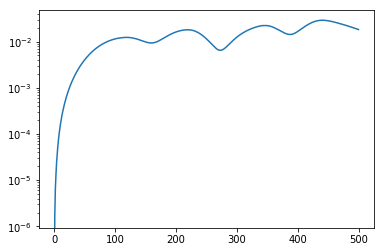

In [21]:
plt.plot(err)
plt.yscale('log')

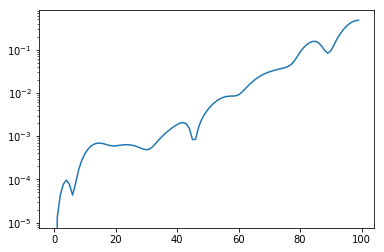

In [72]:
plt.plot(err)
plt.yscale('log')

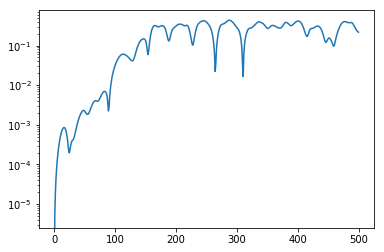

In [39]:
plt.plot(err)
plt.yscale('log')

In [31]:
P.Minv

tensor([[1., 0., -0.],
        [0., 1., -0.],
        [0., 0., 1.]])

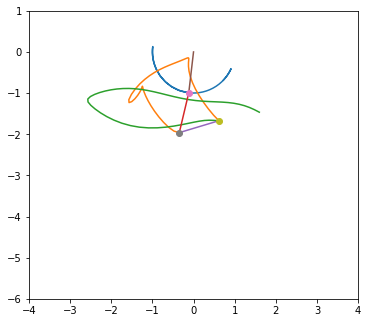

In [18]:
HTML(Animation2d(xt.float(),P,box_lim=(-4,4,-6,1)).animate().to_html5_video())

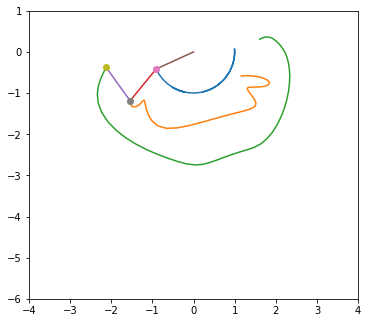

In [19]:
HTML(Animation2d(xt_hat.float(),P,box_lim=(-4,4,-6,1)).animate().to_html5_video())